# Session 2b: Linear regression

Now we will introduce the task of linear regression, the simplest type of machine learning problem.

## Linear Regression

We are first going to introduce a the most basic machine learning problem, that of fitting a line to a set of points.  Consider the following dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# x, y
data = np.array([
    [2.4, 1.7], 
    [2.8, 1.85], 
    [3.2, 1.79], 
    [3.6, 1.95], 
    [4.0, 2.1], 
    [4.2, 2.0], 
    [5.0, 2.7]
])

We have a series of {x,y} pairs. We can plot them with a scatterplot.

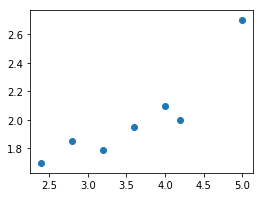

In [2]:
x, y = data[:,0], data[:,1]

plt.figure(figsize=(4, 3))
plt.scatter(x, y)

The goal of linear regression is to find a line, $y = mx + b$ which fits the data points as well as possible. 

What does it mean for it to fit the points "as well as possible"? Let's try three random lines and compare them.  We will define the following three functions as candidates:

$$f1(x) = 0.92x-1.0$$
$$f2(x) = -0.21x+3.4$$
$$f3(x) = 0.52x+0.1$$

In [3]:
def f1(x):
    return 0.92 * x - 1.0

def f2(x):
    return -0.21 * x + 3.4

def f3(x):
    return 0.52 * x + 0.1

# try some examples
print("f1(-1.0) = %0.2f" % f1(-1))
print("f2( 0.0) = %0.2f" % f2(0))
print("f3( 2.0) = %0.2f" % f3(2))

f1(-1.0) = -1.92
f2( 0.0) = 3.40
f3( 2.0) = 1.14


Let's plot all three of these functions and see how well each of them fit the points in our dataset.

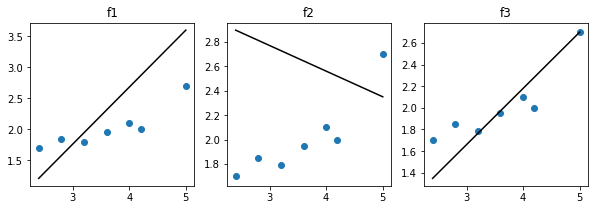

In [4]:
min_x, max_x = min(x), max(x)

fig = plt.figure(figsize=(10,3))

fig.add_subplot(131)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f1(min_x), f1(max_x)], 'k-')
plt.title("f1")

fig.add_subplot(132)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f2(min_x), f2(max_x)], 'k-')
plt.title("f2")

fig.add_subplot(133)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f3(min_x), f3(max_x)], 'k-')
plt.title("f3")

Intuitively, it looks like $f1$ and $f3$ come closest to a good fit, with $f3$ looking somewhat better than $f1$, and $f2$ showing the worst fit. But how do we formally express how good a fit is? We define an "error" or "cost" function, which expresses the total error between the points predicted by the line, and those of the actual dataset.

One very popular measure of this called the "sum squared error," which we will denote as $J$, which is the sum of the square differences between the data points and the line. 

$$ J = \sum{(y_i - f(x_i))^2} $$

Intuitively, for each pair of points $(x_i, y_i)$, the quantity $y_i - f(x_i)$ is the difference between the actual point $y_i$ and the y-value predicted by the line at $x_i$. Then we square them  (to penalize large distances more) and sum them together. 

For $f1$, we plot the error bars, $y_i - f_1(x_i)$ with red dashed lines in the next cell.

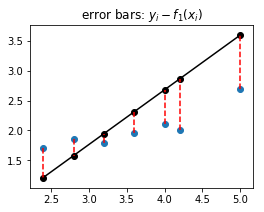

In [5]:
min_x, max_x = min(x), max(x)
fig = plt.figure(figsize=(4,3))
plt.scatter(x, y) # original data points
plt.plot([min_x, max_x], [f1(min_x), f1(max_x)], 'k-') # line of f1
plt.scatter(x, f1(x), color='black') # points predicted by f1
for x_, y_ in zip(x, y):
    plt.plot([x_, x_], [y_, f1(x_)], '--', c='red') # error bars
plt.title("error bars: $y_i-f_1(x_i)$")

Another name for sum squared error is the "quadratic cost." The square root of the sum squared error, $ \sqrt {\sum{(y_i -  f(x_i))^2}} $ is the famous "distance formula" or "euclidean distance." Dividing by the number of elements $n$, we get the mean squared error, $\frac{1}{n} \sum{(y_i -  f(x_i))^2}$, which is the average of the squared differences. All of these cost functions are closely related and are often used interchangeably.

For convenience, sum squared error is very often multiplied by $0.5$. The reason for this will be clear later in this notebook. We redefine the sum squared error as:

$$ J = \frac{1}{2} \sum{(y_i - f(x_i))^2} $$

Since the function $f(x_i) = m x_i + b$, we can substitute that into the cost, and get:

$$ J = \frac{1}{2} \sum{(y_i - (mx_i + b))^2} $$


In [6]:
# sum squared error
def cost(y_pred, y_actual):
    return 0.5 * np.sum((y_actual-y_pred)**2)


In [7]:
x, y = data[:,0], data[:,1]

J1 = cost(f1(x), y)
J2 = cost(f2(x), y)
J3 = cost(f3(x), y)

print("J1=%0.2f, J2=%0.2f, J3=%0.2f" % (J1, J2, J3))

J1=1.18, J2=2.16, J3=0.15


As we expected, the third function has the lowest cost for this dataset, and the second has the highest.

What is a good method for finding the optimal $m$ and $b$ to get the lowest error rate? The simplest way would be the brute force method: have the computer make millions of guesses and keep the one that happens to have the lowest error. Computers are pretty fast, so why not? For our simple problem with two parameters, this would work fine. But in real-world problms, we often have dozens, hundreds, or even millions of parameters which have to be optimized at the same time. Making guesses does not scale to a large number of dimensions; no computer is fast enough to try enough guesses to get a good solution in a reasonable amount of time.

So we need a more formal method for this. We can get an idea of how we might do this by first observing the loss surface. We'll plot the MSE of every combination of $m$ and $b$ within some range and look at it first. Note: recall that for this toy problem, calculating the cost for all combinations of our two parameters is easy to do because there's a small number of combinations. In problems where we have thousands or more parameters, it will be infeasible to do this practically because there will be too many parameter combinations to try (which is the reason we need a better method than brute force guessing to begin with). For 2 parameters, we observe the loss surface just for demonstration purposes.


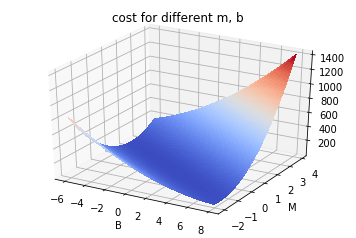

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

# check all combinations of m between [-2, 4] and b between [-6, 8], to precision of 0.1
M = np.arange(-2, 4, 0.1)
B = np.arange(-6, 8, 0.1)

# get MSE at every combination
J = np.zeros((len(M), len(B)))
for i, m_ in enumerate(M):
    for j, b_ in enumerate(B):
        J[i][j] = cost(m_*x+b_, y)

# plot loss surface
B, M = np.meshgrid(B, M)
ax.plot_surface(B, M, J, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
plt.title("cost for different m, b")
plt.xlabel("B")
plt.ylabel("M")

Our loss surface looks a bit like an elongated bowl. Because our goal is to find the parameters $m$ and $b$ which give us the lowest possible error, this translates to finding the point at the bottom of that bowl. By eye, it looks like it's roughly around $m=0, b=2$. 

### Gradient descent

Let's now define a better method for actually finding this point. The method we are going to introduce is called "gradient descent." Note, there is a [much better way to do linear regression](https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/) than to use gradient descent, but we will use gradient descent anyway, because later on, when we introduce neural networks, we shall see that gradient descent is the best way by which to find the optimal parameters for them. So we introduce gradient descent in the context of a simpler problem first.

Gradient descent will be discussed in more detail in the next two sessions. To get ahead, you can read [this ml4a chapter](https://ml4a.github.io/ml4a/how_neural_networks_are_trained/) for a more thorough introduction.

The basic idea behind gradient descent is as follows. Start with a random guess about the parameters, and then calculate the gradient of the loss function with respect to the parameters. Recall from the previous session that the gradient of a function is the vector containing each of the partial derivatives of its variables, i.e.

$$
\nabla f(X) = \left[ \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, ..., \frac{\partial f}{\partial x_n}  \right]
$$

Our loss function $J$ has two parameters: the slope $m$ and y-intercept $b$. Thus its gradient is:

$$
\nabla J = \left[ \frac{\partial J}{\partial m}, \frac{\partial J}{\partial b} \right]
$$

The interpretation of the gradient is that it gives us the slope in every dimension of the loss function at any $m$ and $b$. What gradient descent does is it evaluates the slope of the loss function at the current parameters, and then takes a small step in the exact opposite direction (because the slope is upward). This has the effect of moving $m$ and $b$ to a place where the error is a bit lower than it was before. Repeat this process many times until the loss stops descending (because we have reached the bottom) and you are finished. This is the basic idea.

How can we actually calculate the partial derivatives: $\frac{\partial J}{\partial m}$ and $\frac{\partial J}{\partial b}$? We must differentiate $J$ with respect to these two parameters.

Recall:

$$ J(m,b) = \frac{1}{2} \sum{(y_i - (mx_i + b))^2} $$

Let's start with $\frac{\partial J}{\partial m}$. We can derive its partial derivative with the following steps:

$$ \frac{\partial J}{\partial m} = \frac{\partial}{\partial m} \left[ \frac{1}{2} \sum{(y_i - (mx_i + b))^2} \right]  $$ 

$$ \frac{\partial J}{\partial m} = \frac{1}{2} \sum{ \frac{\partial}{\partial m} (y_i - (mx_i + b))^2}  $$ 

$$ \frac{\partial J}{\partial m} = \frac{1}{2} \sum{ -2 x_i \cdot (y_i - (mx_i + b))}  $$ 

$$ \frac{\partial J}{\partial m} = -\sum{x_i \cdot (y_i - (mx_i + b))} $$

For $\frac{\partial J}{\partial b}$, the partial derivative is found:

$$ \frac{\partial J}{\partial b} = \frac{\partial}{\partial b} \left[ \frac{1}{2} \sum{(y_i - (mx_i + b))^2} \right]  $$ 

$$ \frac{\partial J}{\partial b} = \frac{1}{2} \sum{ \frac{\partial}{\partial b} (y_i - (mx_i + b))^2}  $$ 

$$ \frac{\partial J}{\partial b} = \frac{1}{2} \sum{ -2 \cdot (y_i - (mx_i + b))}  $$ 

$$ \frac{\partial J}{\partial b} = -\sum{(y_i - (mx_i + b))} $$

So to summarize, we have found:

$$ \frac{\partial J}{\partial m} = - \sum{x_i \cdot (y_i - (mx_i + b))} $$
$$ \frac{\partial J}{\partial b} = - \sum{(y_i - (mx_i + b))} $$

We can then define the following update rule, where we calculate the gradient and then adjust the parameters $m$ and $b$:

$$ m := m - \alpha \cdot \frac{\partial J}{\partial m} $$

$$ b := b - \alpha \cdot \frac{\partial J}{\partial b} $$

Where $\alpha$ is a hyperparameter called the "learning rate" that controls the size of the update step. In simple gradient descent, the learning rate must be chosen manually, but as we shall see later, there are more complex variants of gradient descent which automatically pick and adjust the learning rate during training. If we set $\alpha$ too high, we may overshoot the best trajectory, whereas if we set it too low, learning may take an unacceptably long time. Typical values of this are 0.01, 0.001, 0.0001 and so on.

Let's implement this in code:

initial parameters: m=0.800, b=-0.500
initial cost = 1.580
final parameters: m=0.662, b=0.269
final Cost = 0.009


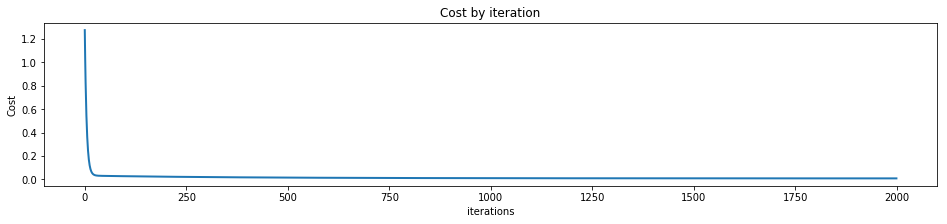

In [11]:
import random

# get our data
x, y = data[:,0], data[:,1]

# it is a good idea to normalize the data
x = x / np.amax(x, axis=0)
y = y / np.amax(y, axis=0)

# choose a random initial m, b
m, b = 0.8, -0.5

def F(x, m, b):
    return m * x + b

# what is our error?
y_pred = F(x, m, b)
init_cost = cost(y_pred, y)

print("initial parameters: m=%0.3f, b=%0.3f"%(m, b))
print("initial cost = %0.3f" % init_cost)

# implement partial derivatives of our parameters
def dJdm(x, y, m, b):
    return -np.dot(x, y - F(x, m, b))

def dJdb(x, y, m, b):
    return -np.sum(y - F(x, m, b))

# choose the alpha parameter and number of iterations
alpha = 0.01
n_iters = 2000

# keep track of error
errors = []
for i in range(n_iters):
    m = m - alpha * dJdm(x, y, m, b)
    b = b - alpha * dJdb(x, y, m, b)
    y_pred = F(x, m, b)
    j = cost(y_pred, y)
    errors.append(j)
    
# plot it

plt.figure(figsize=(16, 3))
plt.plot(range(n_iters), errors, linewidth=2)
plt.title("Cost by iteration")
plt.ylabel("Cost")
plt.xlabel("iterations")

# what is our final error rate
y_pred = F(x, m, b)
final_cost = cost(y_pred, y)

print("final parameters: m=%0.3f, b=%0.3f"%(m, b))
print("final cost = %0.3f" % final_cost)


We can plot the line of best fit:

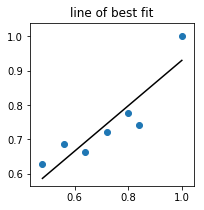

In [12]:
min_x, max_x = min(x), max(x)

fig = plt.figure(figsize=(10,3))

fig.add_subplot(131)
plt.scatter(x, y)
plt.plot([min_x, max_x], [m * min_x + b, m * max_x + b], 'k-')
plt.title("line of best fit")

The procedure that we just demonstrated is called "gradient descent." It's not actually necessary to do linear regression, because linear regression can be solved analytically. However, in the next session we will introduce neural networks, which can not be optimized analytically, and thus will require gradient descent to train.